<a href="https://colab.research.google.com/github/kainspraveen/Local-Global-Attention-Network/blob/main/2phase_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Oct  5 14:53:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.1 MB/s 


# Vi-Transoformer implementation (From Keras Documentation)

x_train shape:  (50000, 32, 32, 3)
x_test shape:  (10000, 32, 32, 3)
y_train shape :  (50000, 1)
y_test shape :  (10000, 1)
Image size: 72 X 72
Patch size: 4 X 4
Patches per image: 324
Elements per patch: 48


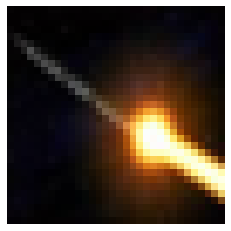

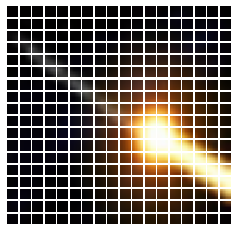

In [ ]:
#Vi-Transformer Implementation
from tensorflow import keras
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow as tf

#Example for CIFAR-100

num_classes=100
input_shape=(32,32,3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()


print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)
print("y_train shape : ", y_train.shape)
print("y_test shape : ", y_test.shape)


#Configure Hyper Parameters
lr=1e-2
weight_decay= 1e-3
batch_size=256
num_epochs=100
image_size=72 #resize images (32,32,3) to (72,72,3)
patch_size=4
num_patches = (image_size//patch_size)**2
projection_dim=128
num_heads=4


transformer_units=[projection_dim*2, projection_dim ] #size of transformer layer

transformer_layers=8
mlp_head_units=[2048, 1024]


#Data Augmentation as Keras Layer

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
     
    ],
    name='data_augmentation'
)

data_augmentation.layers[0].adapt(x_train)


#MLP (Multi Layer Perceptron)
def mlp(x, hidden_units, dropout):
    for units in hidden_units:
        x=layers.Dense(units, activation=tf.nn.gelu)(x)
        x=layers.Dropout(dropout)(x)
    return x

#patch Creation as Layer

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size=patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates= [1,1,1,1],
            padding= 'VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1,patch_dims])
        return patches


#display patches for an image
from matplotlib import pyplot as plt
plt.figure(figsize=(4,4))
image=x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches=Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")



n=int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

for i, patch in enumerate(patches[0]):
    
    ax=plt.subplot(n,n,i+1)
    patch_img=tf.reshape(patch, (patch_size, patch_size, 3))
    #print(patch_img)
    #break
    plt.imshow(patch_img.numpy().astype('int32'))
    plt.axis('off')

#pacth encoding Layer

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches=num_patches
        self.projection=layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim =num_patches, output_dim = projection_dim
        )
        print(type(self.position_embedding))

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch)+self.position_embedding(positions)
        return encoded


#build the Vi-T model

#consists of multiple transformer blocks

def create_vit_classifier():

    inputs=layers.Input(shape=input_shape)


    #augment data
    augmented = data_augmentation(inputs)
    #create patches
    patches = Patches(patch_size)(augmented)

    #encode patches
    temp=PatchEncoder(num_patches,projection_dim)(patches)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block

    for _ in range(transformer_layers):
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1,x1)
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.1)
        #skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    #create a [batch_size, projection_dim] tensor

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    #add mlp

    #features = mlp(representation, hidden_units=mlp_head_units, dropout=0.5)
    #classify outputs

    #logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs = representation)
    return model

    


# 2-Phase Transformer : Variant - 1
### Phase 1 : Local Attention (more like attention within patches)
### Phase 2 : Global Attention of patches from Phase 1

--------------------------------------Encoder Complete------------------------
### {(MLP for Classification), }


Local patches shape  (1, 324, 48)
<class 'keras.layers.embeddings.Embedding'>
* (1, 324, 64)
(1, 162, 128)


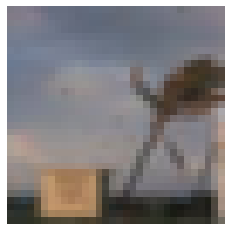

In [ ]:
#local patchmaker and patch encoder
class PatchesLocal(layers.Layer):
    def __init__(self, patch_size, loc_patch_size=0):
        super(PatchesLocal, self).__init__()
        self.patch_size=patch_size
        self.loc_patch_size = loc_patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates= [1,1,1,1],
            padding= 'VALID'
        )
        patch_dims = patches.shape[-1]
        #patches = tf.reshape(patches, [batch_size, -1,patch_dims])
        if (self.loc_patch_size):
            num_patches=patches.shape[1]
            num_local_patches = int((patch_size//self.loc_patch_size)**2)
            loc_patch_dims = int(patch_dims//num_local_patches)
            #patches = np.array(patches)
            #patches=patches.reshape((batch_size,num_patches,num_local_patches,loc_patch_dims))
            #patches = tf.convert_to_tensor(patches)
            patches = tf.reshape(patches, [batch_size,-1,num_local_patches,loc_patch_dims ])
        return patches


class PatchEncoderLocal(layers.Layer):
    def __init__(self, num_patches, projection_dim, num_local_patches):
        super(PatchEncoderLocal, self).__init__()
        self.num_patches=num_patches
        self.num_local_patches= num_local_patches
        self.projection=layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim =num_local_patches, output_dim = projection_dim
        )
        print(type(self.position_embedding))

    def call(self, patch):
        #batch_size=patch.shape[0]
        #loc_patch_dims = patch.shape[-1]//self.num_local_patches
        #patch = tf.reshape(patch, [batch_size,self.num_patches,self.num_local_patches,loc_patch_dims ])
        positions = tf.range(start=0, limit=self.num_local_patches, delta=1)
        encoded = self.projection(patch)+self.position_embedding(positions)
        return encoded

class PatchMerge(layers.Layer):
    def __init__(self, patch_size, num_patches, num_patches_local, patch_size_local, projection_dim_local):
        super(PatchMerge, self).__init__()
        self.patch_size=patch_size
        self.num_patches = num_patches
        self.num_patches_local = num_patches_local
        self.patch_size_local = patch_size_local
        self.projection_dim_local=projection_dim_local
    
    def call(self,patches):
        batch_size = tf.shape(patches)[0]
        #patch_dim_loc = tf.shape(patches)[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, self.num_patches_local*self.projection_dim_local ])
        return patches


class PatchMergeV2(layers.Layer):
    def __init__(self, patch_size, num_patches, dim):
        super(PatchMergeV2, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.dim = dim

    
    def call(self, patches):
        import math
        batch_size = tf.shape(patches)[0]
        patches = tf.reshape(patches, [batch_size, self.num_patches, dim])
        return patches

image=x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)


#patches=Patches(patch_size)(resized_image)
#print(patches.shape)


patches = Patches(4)(resized_image)
print("Local patches shape ", patches.shape)

patch_encoder = PatchEncoder(324, 64)(patches)

#inner_patches = patches[0,0,:,:]
#print(inner_patches.shape)

"""
plt.figure(figsize=(4,4))
n=4
for i, patch in enumerate(inner_patches):
    ax=plt.subplot(n,n,i+1)
    patch_img=tf.reshape(patch, (1, 1, 3))
    #print(patch_img)
    #break
    plt.imshow(patch_img.numpy().astype('int32'))
    plt.axis('off')
print("paytch encoder :", patch_encoder.shape)
"""

print("*",patch_encoder.shape)
merge = PatchMergeV2(2,324,64)(patch_encoder)
print(merge.shape)




In [ ]:
#Architecture for Encoder
from tensorflow.keras.utils import plot_model

lr=1e-2
weight_decay= 1e-3
batch_size=256
num_epochs=100
image_size=72 #resize images (32,32,3) to (72,72,3)
patch_size=4
num_patches = (image_size//patch_size)**2
projection_dim=192
num_heads=4


transformer_units=[projection_dim*2, projection_dim ] #size of transformer layer

transformer_layers=8
mlp_head_units=[2048, 1024]


def phase_former():
    input_shape = (32,32,3)
    inputs = layers.Input(shape = input_shape)
    augmentation = data_augmentation(inputs)

    #patches = Patches(patch_size)(augmentation)
    transformer_layers=4
    patch_size_local=1
    num_patches_local = int((patch_size//patch_size_local)**2)
    projection_dim_local=12
    num_heads_local=8
    transformer_units_local = [projection_dim_local*2, projection_dim_local]


    x1 = PatchesLocal(patch_size=4,loc_patch_size=1)(augmentation)
    encoded_patches = PatchEncoderLocal(324, projection_dim_local, num_patches_local)(x1)

    for _ in range(transformer_layers):

        """
        Phase 1 - Local Attention within patches

        (1,1) for phase 2 patch (4,4); (2,2) for (8,8) and so on..
        number of phases will be such 
        that innermost phase is(1,1) patch size.
        
        """
        
        x3=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        #print(x3.shape)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads_local, key_dim=projection_dim_local, dropout=0.1, attention_axes=(2,3))(encoded_patches,encoded_patches)
        print(attention_output.shape)
        #skip connection 1
        x4=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2

        x5 = layers.LayerNormalization(epsilon=1e-6)(x4)
        x6 = mlp(x5, hidden_units=transformer_units_local, dropout=0.1)
        #skip connection 2
        encoded_patches = layers.Add()([x4, x6])
        print(encoded_patches.shape,"#")


    #Patch Merging from attention output
    patch_merge = PatchMerge(patch_size, num_patches, num_patches_local, patch_size_local, projection_dim_local)(encoded_patches)
    print(patch_merge.shape)

    for _ in range(transformer_layers):

        """Phase 2 - Global Attention Intra-Patches"""
        y1=layers.LayerNormalization(epsilon=1e-6)(patch_merge)
        attention_output_2=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(y1,y1)
        #print(attention_output_2.shape)
        #skip connection 1
        y2=layers.Add()([attention_output_2, patch_merge])
        #layer normalization 2

        y4 = layers.LayerNormalization(epsilon=1e-6)(y2)
        y5 = mlp(y4, hidden_units=transformer_units, dropout=0.1)
        #skip connection 2
        patch_merge = layers.Add()([y5, y2])



    
    #representation  = layers.LayerNormalization(epsilon = 1e-6)(patch_merge)
    representation  = layers.Flatten()(patch_merge)

    dense = mlp(representation, hidden_units = [2048, 1024], dropout = 0.3)
    logits = layers.Dense(units = 100)(dense)
    
    model= keras.Model(inputs = inputs, outputs = logits)

    return model










In [ ]:
#Model for Classification
tf.keras.backend.clear_session()
phase_former = phase_former()
phase_former.summary()
plot_model(phase_former, to_file = 'phase_former.png', show_shapes = True)
phase_former.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )


NameError: ignored

In [ ]:
#Training
history = phase_former.fit(x_train, y_train, batch_size=50, epochs=150, verbose =1, validation_data = (x_test, y_test))


NameError: ignored

In [ ]:
#Analysis
phase_former.evaluate(x_test, y_test)

# Phase Former Varaint 2
###  uses multiple phases only upscaling the patches rather than starting from ground (1x1)
### should compare both variants and understand the tradeoffs!!

In [ ]:
#Architecture for Encoder
from tensorflow.keras.utils import plot_model

def phase_former_v2():
    lr=1e-2
    weight_decay= 1e-3
    batch_size=256
    num_epochs=100
    image_size=72 #resize images (32,32,3) to (72,72,3)
    patch_size=36
    num_patches = (image_size//patch_size)**2
    projection_dim=4
    num_heads=4


    transformer_units=[projection_dim*2, projection_dim ] #size of transformer layer

    transformer_layers=4
    mlp_head_units=[2048, 1024]

    inputs=layers.Input(shape=input_shape)


    #augment data
    augmented = data_augmentation(inputs)
    #create patches
    patches = Patches(patch_size)(augmented)
    #print(patches.shape)

    #encode patches
    temp=PatchEncoder(num_patches,projection_dim)(patches)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    #create multiple layrs of the transformer block

    for _ in range(transformer_layers):
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1,x1)
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.1)
        #skip connection 2
        encoded_patches = layers.Add()([x3, x2])


    """Patch Merge 1 """
    #print(encoded_patches.shape)
    #num_patches = num_patches//2
    num_patches = (72//18)**2
    projection_dim = 18*18*3
    print(num_patches)
    
    encoded_patches = PatchMergeV2(18,num_patches, projection_dim)(encoded_patches)
    #projection_dim*=2
    transformer_units = [projection_dim*2, projection_dim]
    
    #print(patch_merge.shape)



    """PHASE 2"""

    for _ in range(transformer_layers):
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        #print(projection_dim)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1,x1)
        #print(attention_output.shape)
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #print(x2.shape)
        #layer normalization 2

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.1)
        #print(x3.shape)
        #skip connection 2
        encoded_patches = layers.Add()([x3, x2])
    
    """Patch Merge 2"""
    num_patches = (72//9)**2
    projection_dim = 9*9*3
    encoded_patches = PatchMergeV2(9,num_patches, projection_dim)(encoded_patches)
    #projection_dim*=2
    transformer_units = [projection_dim*2, projection_dim]



    """PHASE 3 """

    for _ in range(transformer_layers):
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1,x1)
        #print(attention_output.shape)
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.1)
        #skip connection 2
        encoded_patches = layers.Add()([x3, x2])
    
    """Patch Merge 3"""
    num_patches = (72//4)**2
    projection_dim = 4*4*3
    encoded_patches = PatchMergeV2(1/81,num_patches, projection_dim)(encoded_patches)
    #projection_dim*=2
    transformer_units = [projection_dim*2, projection_dim]



    """PHASE 4 """

    for _ in range(transformer_layers):
        #layer normalization
        x1=layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output=layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1,x1)
        #print(attention_output.shape)
        #skip connection 1
        x2=layers.Add()([attention_output, encoded_patches])
        #layer normalization 2

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout=0.1)
        #skip connection 2
        encoded_patches = layers.Add()([x3, x2])



    
    representation  = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation  = layers.Flatten()(representation)

    dense = mlp(representation, hidden_units = [2048, 1024], dropout = 0.3)
    logits = layers.Dense(units = 100)(dense)
    
    model= keras.Model(inputs = inputs, outputs = logits)

    return model



In [ ]:
#Model for Classification

phase_former_v2 = phase_former_v2()
phase_former_v2.summary()
plot_model(phase_former_v2, to_file = 'phase_former_v2.png', show_shapes = True)
phase_former_v2.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-4), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"), keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc")] )
plot_model(phase_former_v2, to_file = 'v2model.png', show_shapes=True)

<class 'keras.layers.embeddings.Embedding'>
<class 'keras.layers.embeddings.Embedding'>
16


ResourceExhaustedError: ignored

In [ ]:
#Analysis
history = phase_former_v2.fit(x_train, y_train, epochs = 150, batch_size=130, validation_data=(x_test,y_test))
phase_former_v2.evaluate(x_test, y_test)

Epoch 1/150


InvalidArgumentError: ignored

# Analysis Overall and Save

In [ ]:
#Save Analysis

# Sparse Local Attention Transformer Encoder
### Only attends to 'k' surrounding neighbours in 8 directions
### 'k' is for simplicity pre-determined bassed on input size. However it can be made as learnable parameter.
### for each patch 'i', 'k' surrounding similar patches are merged into a singe patch to input into global attention module.

---------------------------Encoder Complete-----------------------------------

### Decoder : {(MLP for Classification), }


In [ ]:
#Encoder Architecture

In [ ]:
#Classification Model

In [ ]:
#Training

In [ ]:
#Analysis

In [ ]:
#Save Analysis

#Extra Cross-Model Comparisons and Studies

# Final Thoughts and Conclusion

In [ ]:
#The End